# Oriented R-CNN for Object Detection

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.ops import boxes as box_ops, nms
import kagglehub
import shutil
import os
from PIL import Image
import xml.etree.ElementTree as ET
import math
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.ops.feature_pyramid_network import LastLevelMaxPool
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
import detectron2
from torchvision import models
from detectron2.layers import ROIAlignRotated

In [5]:
base_path = "/content/drive/My Drive/Colab Notebooks/HW3"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Prepare Data set

In [ ]:
dataset_temp_path = kagglehub.dataset_download('weiming97/hrsc2016-ms-dataset')

destination_path = os.path.join(base_path, 'HRSC2016')

#shutil.copytree(dataset_temp_path, destination_path)

In [6]:
class HRSC2016Dataset(Dataset):
    def __init__(self, image_dir, annotation_dir, image_list_file, transform=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transform = transform

        with open(image_list_file, 'r') as f:
            self.image_ids = [line.strip() for line in f.readlines()]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f"{img_id}.bmp")
        ann_path = os.path.join(self.annotation_dir, f"{img_id}.xml")

        image = Image.open(img_path).convert("RGB")

        tree = ET.parse(ann_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall("object"):
            robndbox = obj.find("robndbox")
            if robndbox is None:
                continue

            cx = float(robndbox.find("cx").text)
            cy = float(robndbox.find("cy").text)
            w = float(robndbox.find("w").text)
            h = float(robndbox.find("h").text)
            angle = float(robndbox.find("angle").text)

            x, y = cx, cy

            cos_a = math.cos(angle)
            sin_a = math.sin(angle)

            dx = w / 2
            dy = h / 2

            v1 = (cx - dx * cos_a + dy * sin_a, cy - dx * sin_a - dy * cos_a)  # top-left
            v2 = (cx + dx * cos_a + dy * sin_a, cy + dx * sin_a - dy * cos_a)  # top-right
            v3 = (cx + dx * cos_a - dy * sin_a, cy + dx * sin_a + dy * cos_a)  # bottom-right
            v4 = (cx - dx * cos_a - dy * sin_a, cy - dx * sin_a + dy * cos_a)  # bottom-left

            xs = [v1[0], v2[0], v3[0], v4[0]]
            ys = [v1[1], v2[1], v3[1], v4[1]]
            w_ext = max(xs) - min(xs)
            h_ext = max(ys) - min(ys)


            top_mid = (x, y - h_ext / 2)
            right_mid = (x + w_ext / 2, y)

            if v1[0] <= v2[0]:
              delta_alpha = v1[0] - top_mid[0]
              delta_beta = v2[1] - right_mid[1]
            else:
              delta_alpha = v4[0] - top_mid[0]
              delta_beta = v1[1] - right_mid[1]

            boxes.append([x, y, w_ext, h_ext, delta_alpha, delta_beta])
            labels.append(1)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels
        }

        if self.transform:
            image = self.transform(image)

        return image, target


In [7]:
transform = transforms.ToTensor()

image_dir = base_path + "/HRSC2016/AllImages"
annotation_dir = base_path + "/HRSC2016/Annotations"
image_sets_dir = base_path + "/HRSC2016/ImageSets"


train_dataset = HRSC2016Dataset(image_dir, annotation_dir, os.path.join(image_sets_dir, "train.txt"), transform)
val_dataset = HRSC2016Dataset(image_dir, annotation_dir, os.path.join(image_sets_dir, "val.txt"), transform)
test_dataset = HRSC2016Dataset(image_dir, annotation_dir, os.path.join(image_sets_dir, "test.txt"), transform)


In [8]:
def draw_midpoint_offset_box(ax, box, color='red'):
    x, y, w, h, da, db = box.tolist()

    v1 = (x + da, y - h/2)
    v2 = (x + w/2, y + db)
    v3 = (x - da, y + h/2)
    v4 = (x - w/2, y - db)

    polygon = patches.Polygon([v1, v2, v3, v4], closed=True, fill=False, edgecolor=color, linewidth=2)
    ax.add_patch(polygon)

def visualize_examples(dataset, num_samples=3):
    for i in range(num_samples):
        image, target = dataset[i]
        image_np = image.permute(1, 2, 0).numpy()

        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        ax.imshow(image_np)

        for box in target['boxes']:
            draw_midpoint_offset_box(ax, box)

        ax.set_title(f"Sample {i} with {len(target['boxes'])} bounding box(es)")
        plt.axis('off')
        plt.show()

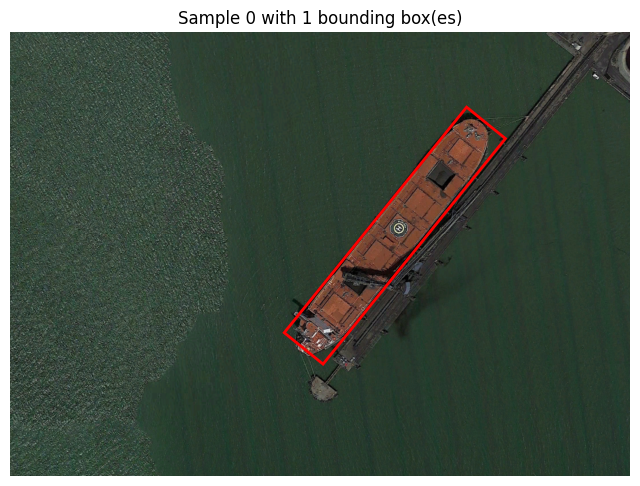

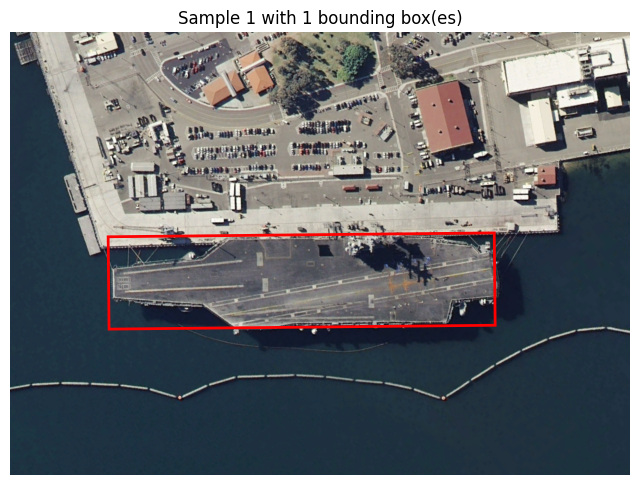

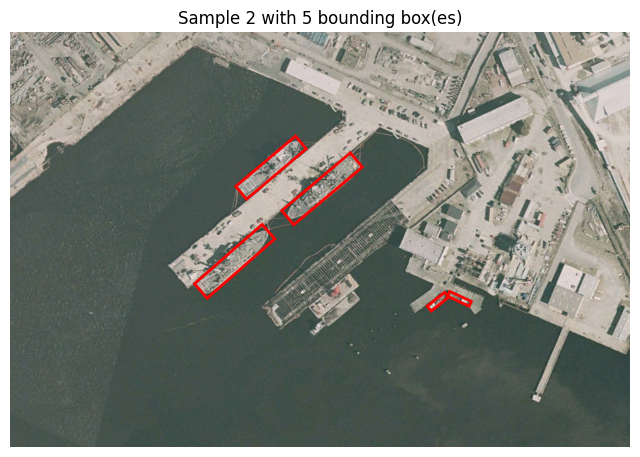

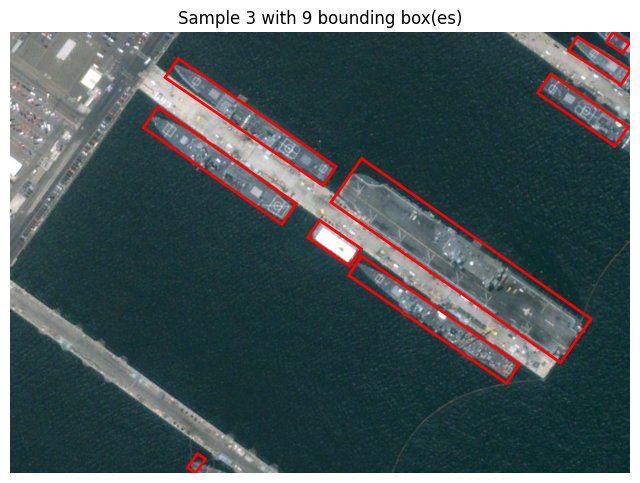

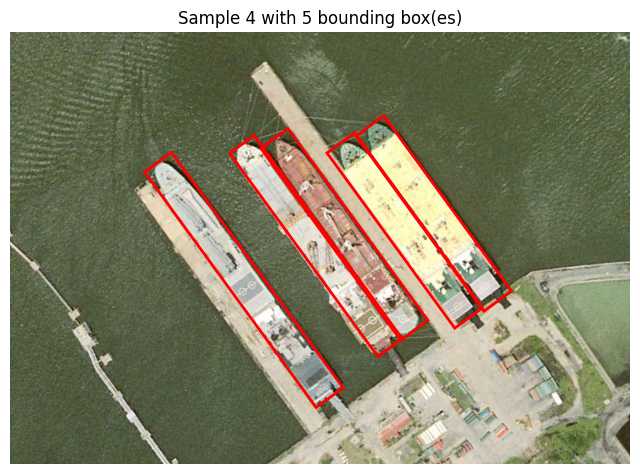

In [ ]:
visualize_examples(train_dataset, num_samples=5)

## Training R-CNN model

### Model Implementation

#### Backbone:

In [40]:
class BackboneWithFPN(nn.Module):

    def __init__(self, out_channels=256):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        self.conv1 = resnet.conv1
        self.bn1   = resnet.bn1
        self.relu  = resnet.relu
        self.maxpool = resnet.maxpool

        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4


        self.latlayer0 = nn.Conv2d(2048, out_channels, 1)
        self.latlayer1 = nn.Conv2d(1024, out_channels, 1)
        self.latlayer2 = nn.Conv2d(512, out_channels, 1)
        self.latlayer3 = nn.Conv2d(256, out_channels, 1)

        self.smooth5 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.smooth4 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.smooth3 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.smooth2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)

        self.p6_conv  = nn.Conv2d(out_channels, out_channels, 3, stride=2, padding=1)

    def forward(self, x):

        c1 = self.relu(self.bn1(self.conv1(x)))
        c1 = self.maxpool(c1)
        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        p5 = self.latlayer0(c5)
        p4 = self.latlayer1(c4) + F.interpolate(p5, size=c4.shape[-2:], mode='nearest')
        p3 = self.latlayer2(c3) + F.interpolate(p4, size=c3.shape[-2:], mode='nearest')
        p2 = self.latlayer3(c2) + F.interpolate(p3, size=c2.shape[-2:], mode='nearest')

        p5 = self.smooth5(p5)
        p4 = self.smooth4(p4)
        p3 = self.smooth3(p3)
        p2 = self.smooth2(p2)
        p6 = self.p6_conv(p5)

        return {"P2": p2, "P3": p3, "P4": p4, "P5": p5, "P6": p6}


#### RPN Head:

In [41]:
class OrientedRPN(nn.Module):

    def __init__(self, in_channels, anchor_ratios=[0.5, 1.0, 2.0]):
        super().__init__()
        self.anchor_ratios = anchor_ratios
        self.num_anchors = len(anchor_ratios)
        self.conv = nn.Conv2d(in_channels, in_channels, 3, padding=1)
        self.cls_conv = nn.Conv2d(in_channels, self.num_anchors * 2, 1)
        self.reg_conv = nn.Conv2d(in_channels, self.num_anchors * 6, 1)

    def forward_single(self, feature):
        t = F.relu(self.conv(feature))
        cls = self.cls_conv(t)
        reg = self.reg_conv(t)
        return cls, reg

    def forward(self, features):

        logits = []
        bbox_regs = []
        for level_name, feat in features.items():
            cls_out, reg_out = self.forward_single(feat)

            N, C1, H, W = cls_out.shape
            _, C2, _, _ = reg_out.shape

            cls_out = cls_out.view(N, self.num_anchors, 2, H, W)
            cls_out = cls_out.permute(0,1,3,4,2).contiguous().view(N, -1, 2)

            reg_out = reg_out.view(N, self.num_anchors, 6, H, W)
            reg_out = reg_out.permute(0,1,3,4,2).contiguous().view(N, -1, 6)
            logits.append(cls_out)
            bbox_regs.append(reg_out)

        cls_logits = torch.cat(logits, dim=1)
        reg_preds  = torch.cat(bbox_regs, dim=1)
        return cls_logits, reg_preds

    def decode_proposals(self, anchors, deltas):

        anchors = anchors.to(deltas.device)

        ax = anchors[:, 0]; ay = anchors[:, 1]
        aw = anchors[:, 2]; ah = anchors[:, 3]
        dx = deltas[:, 0]; dy = deltas[:, 1]
        dw = deltas[:, 2]; dh = deltas[:, 3]
        dalpha = deltas[:, 4]; dbeta = deltas[:, 5]

        w = aw * torch.exp(dw)
        h = ah * torch.exp(dh)
        x = ax + dx * aw
        y = ay + dy * ah
        DeltaAlpha = dalpha * w
        DeltaBeta  = dbeta  * h
        proposals = torch.stack([x, y, w, h, DeltaAlpha, DeltaBeta], dim=1)
        return proposals

    def generate_anchors(self, feature_shapes, feature_strides):

        anchors_all = []

        base_areas = {"P2":32**2, "P3":64**2, "P4":128**2, "P5":256**2, "P6":512**2}
        for level, (H, W) in feature_shapes.items():
            stride = feature_strides[level]
            area = base_areas[level]
            anchors = []
            for ratio in self.anchor_ratios:
                h = math.sqrt(area * ratio)
                w = area / h
                anchors.append((w, h))
            anchors = torch.tensor(anchors, dtype=torch.float32)

            shifts_x = torch.arange(0, W*stride, step=stride) + stride/2
            shifts_y = torch.arange(0, H*stride, step=stride) + stride/2
            shift_y, shift_x = torch.meshgrid(shifts_y, shifts_x)
            shift_x = shift_x.reshape(-1); shift_y = shift_y.reshape(-1)

            K = len(shift_x)
            A = anchors.shape[0]
            anchor_centers = torch.stack([shift_x, shift_y], dim=1)
            anchor_centers = anchor_centers.unsqueeze(1).repeat(1, A, 1).view(-1,2)
            wh = anchors.unsqueeze(0).repeat(K, 1, 1).view(-1,2)
            level_anchors = torch.cat([anchor_centers, wh], dim=1)
            anchors_all.append(level_anchors)
        return torch.cat(anchors_all, dim=0)


#### Rotated RoIAlign:

In [43]:
class RotatedRoIAlign(nn.Module):
    def __init__(self, output_size=(7, 7), sampling_ratio=2):
        super().__init__()
        self.output_size = output_size
        self.sampling_ratio = sampling_ratio
        self.spatial_scales = {
            "P2": 1.0 / 4,
            "P3": 1.0 / 8,
            "P4": 1.0 / 16,
            "P5": 1.0 / 32,
            "P6": 1.0 / 64,
        }
        self.align_ops = nn.ModuleDict({
            level: ROIAlignRotated(
                output_size=output_size,
                spatial_scale=scale,
                sampling_ratio=sampling_ratio
            )
            for level, scale in self.spatial_scales.items()
        })

    def forward(self, feats, proposals):
        device = next(iter(feats.values())).device

        batch_idx = proposals[:, 0]
        cx = proposals[:, 1]
        cy = proposals[:, 2]
        w = proposals[:, 3]
        h = proposals[:, 4]
        da = proposals[:, 5]
        db = proposals[:, 6]
        angle_rad = torch.where(w > h, torch.atan2(2 * db, w), torch.atan2(2 * da, h))
        angle_deg = angle_rad * (180.0 / torch.pi)

        rois = torch.stack([batch_idx, cx, cy, w, h, angle_deg], dim=1).to(device)

        levels = torch.floor(4 + torch.log2(torch.sqrt(w * h) / 224 + 1e-6))
        levels = torch.clamp(levels, 2, 6).int()

        output_feats = torch.zeros(
            (proposals.size(0), feats["P2"].shape[1], *self.output_size),
            device=device,
            dtype=feats["P2"].dtype
        )

        for level in range(2, 7):
            mask = (levels == level)
            if mask.sum() == 0:
                continue
            rois_l = rois[mask]
            feat_l = feats[f"P{level}"]
            pooled = self.align_ops[f"P{level}"](feat_l, rois_l)
            output_feats[mask] = pooled

        return output_feats


#### R-CNN Head:

In [44]:
class OrientedRCNNHead(nn.Module):

    def __init__(self, in_channels, num_classes):
        super().__init__()
        hidden_dim = 1024
        self.fc1 = nn.Linear(in_channels, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

        self.cls_score = nn.Linear(hidden_dim, num_classes + 1)

        self.bbox_pred = nn.Linear(hidden_dim, (num_classes) * 6)
        self.num_classes = num_classes

    def forward(self, roi_features):
        x = F.relu(self.fc1(roi_features))
        x = F.relu(self.fc2(x))
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)
        return scores, bbox_deltas


#### Oriented R-CNN (Full model):

In [45]:
class OrientedRCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = BackboneWithFPN()
        self.rpn = OrientedRPN(in_channels=256)
        self.roi_align = RotatedRoIAlign(output_size=(7,7))
        self.head = OrientedRCNNHead(in_channels=256*7*7, num_classes=num_classes)
        self.num_classes = num_classes

    def forward(self, images, targets=None):

        device = images[0].device
        N = len(images)


        feats = self.backbone(torch.stack(images))


        cls_logits, reg_preds = self.rpn(feats)


        feature_shapes = {lvl: feats[lvl].shape[-2:] for lvl in feats}
        feature_strides = {"P2":4, "P3":8, "P4":16, "P5":32, "P6":64}
        anchors = self.rpn.generate_anchors(feature_shapes, feature_strides).to(device)


        proposals_list = []
        scores_list = []
        topk = 500

        for i in range(N):
            cls_per_img = cls_logits[i]
            reg_per_img = reg_preds[i]


            proposals = self.rpn.decode_proposals(anchors, reg_per_img)


            scores = F.softmax(cls_per_img, dim=1)[:, 1]

            topk_indices = scores.topk(min(topk, scores.size(0)))[1]
            proposals = proposals[topk_indices]
            scores = scores[topk_indices]

            batch_idx = torch.full((proposals.size(0),1), i, device=device)
            proposals_with_batch = torch.cat([batch_idx, proposals], dim=1)

            proposals_list.append(proposals_with_batch)
            scores_list.append(scores)

        proposals_all = torch.cat(proposals_list, dim=0)
        scores_all = torch.cat(scores_list, dim=0)

        roi_feats = self.roi_align(feats, proposals_all)

        roi_feats_flat = roi_feats.flatten(start_dim=1)

        class_logits, bbox_deltas = self.head(roi_feats_flat)

        if self.training:
            losses = {
                "rpn_cls_loss": torch.tensor(0.0, device=device),
                "rpn_reg_loss": torch.tensor(0.0, device=device),
                "rcnn_cls_loss": torch.tensor(0.0, device=device),
                "rcnn_reg_loss": torch.tensor(0.0, device=device),
            }
            return losses

        else:
            scores = F.softmax(class_logits, dim=1)
            labels = scores.argmax(dim=1)

            keep = labels > 0
            proposals_kept = proposals_all[keep]
            scores_kept = scores[keep, labels[keep]]
            labels_kept = labels[keep] - 1

            bbox_deltas_kept = bbox_deltas[keep]
            bbox_deltas_kept = bbox_deltas_kept.view(-1, self.num_classes, 6)

            idx = labels_kept.unsqueeze(1).unsqueeze(2).expand(-1, 1, 6)
            pred_deltas = bbox_deltas_kept.gather(1, idx).squeeze(1)


            anchors_kept = proposals_kept[:, 1:7]
            refined_boxes = anchors_kept + pred_deltas

            detections = []
            for i in range(N):
                mask = proposals_kept[:,0] == i
                boxes_i = refined_boxes[mask]
                scores_i = scores_kept[mask]
                labels_i = labels_kept[mask]
                detections.append({
                    "boxes": boxes_i,
                    "scores": scores_i,
                    "labels": labels_i
                })
            return detections


#### Training:

In [ ]:
K = 1
model = OrientedRCNN(num_classes=K).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=lambda x: list(zip(*x)))
val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: list(zip(*x)))

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    num_train_batches = 0

    print(f"\nEpoch [{epoch+1}/{num_epochs}]")

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

        optimizer.zero_grad()
        losses = model(images, targets)
        total_loss = sum(losses.values())
        total_loss.backward()
        optimizer.step()

        total_train_loss += total_loss.item()
        num_train_batches += 1

    avg_train_loss = total_train_loss / num_train_batches
    print(f"  Train Loss: {avg_train_loss:.4f}")

    scheduler.step()

    model.eval()
    total_val_loss = 0.0
    num_val_batches = 0

    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

            losses = model(images, targets)
            total_loss = sum(losses.values())

            total_val_loss += total_loss.item()
            num_val_batches += 1

    avg_val_loss = total_val_loss / num_val_batches if num_val_batches > 0 else 0
    print(f"  Val Loss:   {avg_val_loss:.4f}")


#### Evaluation: